In [1]:
%matplotlib inline
import os
import json
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
save_path = "./toSave/"

from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
from collections.abc import Sequence

import sklearn.feature_extraction.text as sk_text
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

2023-12-30 10:57:28.000752: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.values.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()



In [3]:
business_names_array = ["McDonald's", "Target", "Chipotle Mexican Grill", "Barnes & Noble Booksellers", "Walmart Supercenter"]

business_data = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)
business_data_fixed = business_data[(business_data['review_count'] >= 20) & 
    (business_data['name'].isin(business_names_array))]
business_data_fixed.to_json('yelp_academic_dataset_business_fixed.json', orient='records', lines=True)

In [4]:
outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL) 
sfile.writerow(['business_id','stars', 'text'])

with open('yelp_dataset/yelp_academic_dataset_review.json', encoding="utf-8") as f: 
    for line in f:
        row = json.loads(line)

        if row['business_id'] in business_data_fixed['business_id'].values:
            # some special char must be encoded in 'utf-8' 
            sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])
outfile.close()


df= pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8")

In [5]:
df

,business_id,stars,text
0,W7NxQw8UYFR0HLPrI08tvw,4.0,"b""Don't know what it is but If my tummy's feel..."
1,QSA-x2bb3kum9QLFpy7vUg,2.0,"b'This is the McDonalds closest to my home, bu..."
2,kgMEBZG6rjkGeFzPaIM4MQ,1.0,b'I know I shouldn\'t expect much but everythi...
3,L7i_5DydYEKwPLfcDBRYDA,5.0,b'This Chipotle location was great! I wanted t...
4,C3Nc7EUqo64jRPWPn6vY9w,3.0,"b'Well I did visit here a Year ago, long befor..."
...,...,...,...
32868,o8XwYGCtUi-emGSxTkOECQ,2.0,"b""Literally the worst chipotle I have ever bee..."
32869,3UHXD8T80OUFMCzLb3x-sQ,1.0,b'This place smells like a cow pasture. Floor ...
32870,FNjY9rzdB0j-DYuKC0DmOw,3.0,"b""Ahhhh Target. You are a necessary evil, only..."
32871,GD0_sWqURBSZARKgNgbwRg,1.0,b'Despite their sign saying they open at 7 am;...


In [6]:
review = pd.read_json('yelp_dataset/yelp_academic_dataset_review.json', lines=True, nrows = 1000000) 
business = pd.read_json('yelp_academic_dataset_business_fixed.json', lines=True, nrows = 1000000)

In [7]:
df_review_agg = df.groupby('business_id')['text'].sum()
df_ready_for_sklearn = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews': 
    df_review_agg.values})

In [8]:
df_ready_for_sklearn

,business_id,all_reviews
0,-0m4IwD1FIOqkA8dh4mVfQ,b'I was very disappointed. The chips were stal...
1,-9yzQQ0d_rcOD2CzdTNO_Q,"b""NASTY NASTY NASTY!!!!!! Steer clear. I've b..."
2,-LI-pZMk96s4VqGwIU1dNg,"b""Tempted to give this location a 1. Stopped i..."
3,-YljbQMbbTC9jwn8kOLitA,b'Worst McDonald\'s I\'ve ever encountered. Tw...
4,-ajaASaDA_77I6pK3D4YgQ,b'My husband and I went to Chipotle for lunch ...
...,...,...
692,zi5cMfvS1imWog3TFfuFnA,b'Excellent and friendly staff! We have gotten...
693,zkUGrri25CXfZc4OS2BtPg,"b""If I could give this half a star I would.. t..."
694,zszv_H7xTUo6SjCebQbbGg,"b""Normally, the McDonalds I go to act just lik..."
695,ztFGiRmX7HPoKMKbgkP17w,"b""coming to this Chipotle was disappointing. m..."


In [54]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english',
                             #max_features=1000,
                             min_df=10, 
                             max_df=25000
                             )
matrix = vectorizer.fit_transform(df_ready_for_sklearn['all_reviews'])
tfidf_data = matrix.toarray()
print(tfidf_data.shape)
print(vectorizer.get_feature_names_out())
tfidf_data

(697, 6874)
['00' '000' '00am' ... 'zombies' 'zone' 'zoo']


array([[0.01251321, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.06541782, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01890035, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [55]:

merged_df = pd.merge(df_ready_for_sklearn, business[['business_id', 'stars']], on='business_id', how='inner')
merged_df

,business_id,all_reviews,stars
0,-0m4IwD1FIOqkA8dh4mVfQ,b'I was very disappointed. The chips were stal...,2.0
1,-9yzQQ0d_rcOD2CzdTNO_Q,"b""NASTY NASTY NASTY!!!!!! Steer clear. I've b...",2.0
2,-LI-pZMk96s4VqGwIU1dNg,"b""Tempted to give this location a 1. Stopped i...",1.5
3,-YljbQMbbTC9jwn8kOLitA,b'Worst McDonald\'s I\'ve ever encountered. Tw...,1.0
4,-ajaASaDA_77I6pK3D4YgQ,b'My husband and I went to Chipotle for lunch ...,2.0
...,...,...,...
692,zi5cMfvS1imWog3TFfuFnA,b'Excellent and friendly staff! We have gotten...,2.0
693,zkUGrri25CXfZc4OS2BtPg,"b""If I could give this half a star I would.. t...",1.5
694,zszv_H7xTUo6SjCebQbbGg,"b""Normally, the McDonalds I go to act just lik...",2.0
695,ztFGiRmX7HPoKMKbgkP17w,"b""coming to this Chipotle was disappointing. m...",4.0


In [56]:
x = tfidf_data
y = merged_df['stars']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

Epoch 1/500
19/19 - 1s - loss: 1.0408 - val_loss: 0.4218 - 955ms/epoch - 50ms/step
Epoch 2/500
19/19 - 1s - loss: 0.3761 - val_loss: 0.3084 - 551ms/epoch - 29ms/step
Epoch 3/500
19/19 - 1s - loss: 0.3034 - val_loss: 0.2774 - 549ms/epoch - 29ms/step
Epoch 4/500
19/19 - 1s - loss: 0.2512 - val_loss: 0.2269 - 553ms/epoch - 29ms/step
Epoch 5/500
19/19 - 1s - loss: 0.2178 - val_loss: 0.2072 - 552ms/epoch - 29ms/step
Epoch 6/500
19/19 - 1s - loss: 0.1980 - val_loss: 0.1978 - 558ms/epoch - 29ms/step
Epoch 7/500
19/19 - 1s - loss: 0.1841 - val_loss: 0.1902 - 554ms/epoch - 29ms/step
Epoch 8/500
19/19 - 1s - loss: 0.1746 - val_loss: 0.1881 - 546ms/epoch - 29ms/step
Epoch 9/500
19/19 - 1s - loss: 0.1669 - val_loss: 0.1784 - 549ms/epoch - 29ms/step
Epoch 10/500
19/19 - 1s - loss: 0.1612 - val_loss: 0.1702 - 540ms/epoch - 28ms/step
Epoch 11/500
19/19 - 1s - loss: 0.1560 - val_loss: 0.1690 - 540ms/epoch - 28ms/step
Epoch 12/500
19/19 - 1s - loss: 0.1456 - val_loss: 0.1618 - 539ms/epoch - 28ms/step
E

/Users/clemente/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/clemente/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


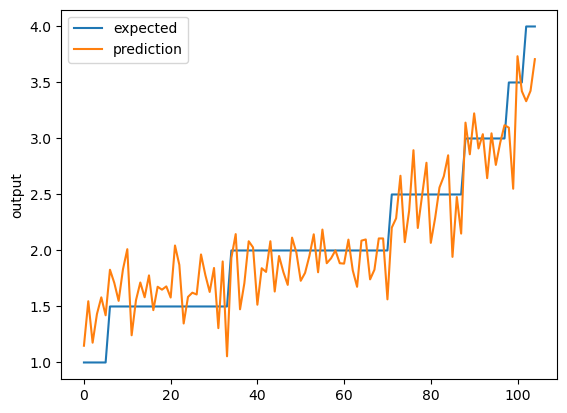

In [60]:
model = Sequential()

# activation_terms = ['relu', 'tanh', 'sigmoid']
# optimizer_terms = ['adam','sgd']
# for i in activation_terms:
#     for j in optimizer_terms:
model.add(Dense(1802, input_dim=x.shape[1], activation = 'relu'))
model.add(Dense(456))
model.add(Dense(170))
model.add(Dense(7))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=10, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights/best_weights.hdf5", verbose=0, save_best_only=True)
model.fit(  x_train,
            y_train,
            validation_data=(x_test,y_test),
            callbacks=[monitor,checkpointer],
            verbose=2,
            epochs=500) 

model.load_weights('best_weights/best_weights.hdf5')
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

model.save(os.path.join(save_path,"network.hdf5"))
chart_regression(pred.flatten(),y_test, sort= True)

In [58]:
# # model.compile(loss='mean_squared_error', optimizer='adam') # adam, sgd
# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
# checkpointer = ModelCheckpoint(filepath="best_weights/best_weights.hdf5", verbose=0, save_best_only=True)
# model.fit(  x_train,
#             y_train,
#             validation_data=(x_test,y_test),
#             callbacks=[monitor,checkpointer],
#             verbose=2,
#             epochs=500)

In [59]:
for this_business_id, star_rating, predicted_rating in zip(merged_df['business_id'], merged_df['stars'], pred):
    business_name = business_data_fixed.loc[business_data_fixed['business_id'] == this_business_id, 'name'].values[0]
    print(f"Business Name: {business_name},\n   True Star Rating: {star_rating},\n   Predicted Rating: {predicted_rating}")


Business Name: Chipotle Mexican Grill,
   True Star Rating: 2.0,
   Predicted Rating: [2.073933]
Business Name: McDonald's,
   True Star Rating: 2.0,
   Predicted Rating: [1.9152085]
Business Name: Chipotle Mexican Grill,
   True Star Rating: 1.5,
   Predicted Rating: [2.0197656]
Business Name: McDonald's,
   True Star Rating: 1.0,
   Predicted Rating: [3.8770583]
Business Name: Chipotle Mexican Grill,
   True Star Rating: 2.0,
   Predicted Rating: [1.7800331]
Business Name: Target,
   True Star Rating: 3.5,
   Predicted Rating: [2.4717128]
Business Name: McDonald's,
   True Star Rating: 1.5,
   Predicted Rating: [3.1374261]
Business Name: McDonald's,
   True Star Rating: 1.5,
   Predicted Rating: [3.0597374]
Business Name: Chipotle Mexican Grill,
   True Star Rating: 2.5,
   Predicted Rating: [1.8447534]
Business Name: McDonald's,
   True Star Rating: 1.5,
   Predicted Rating: [1.3502531]
Business Name: McDonald's,
   True Star Rating: 2.0,
   Predicted Rating: [2.0261536]
Business Na